In [1]:
# mount data
from google.colab import drive
drive.mount('/content/drive')
data_folder = '/content/drive/MyDrive/Thesis/data'

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

#from sklearn.metrics import mean_squared_error

#from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

# settings
plt.style.use("seaborn-paper")
plt.rcParams["figure.figsize"] = (8, 6)

<ipython-input-2-33013544e223>:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


## Load T2 data

In [3]:
def load_T2_data(country_name):
  T2_balances = pd.read_excel(data_folder+'/TGB_month_avg.xls',header=1)
  country = [x for x in T2_balances['REF_AREA.265 [desc.]'].unique() if country_name in x][0]
  col_to_use = ['Obs. date','Obs. value']
  country_T2 = T2_balances[T2_balances['REF_AREA.265 [desc.]']== country]
  country_T2 = country_T2[col_to_use].reset_index(drop=True)
  country_T2.rename(columns={'Obs. value':'T2_balance','Obs. date':'date'},inplace=True)
  country_T2 = country_T2.sort_values('date',ascending=True).reset_index(drop=True)
  country_T2['date'] = pd.to_datetime(country_T2.date).dt.to_period('M')
  return country_T2

In [4]:
# load Spain T2
Spain_T2 = load_T2_data('Spain')

In [5]:
# calculate the monthly change
Spain_T2['1st_diff'] = Spain_T2['T2_balance'].diff(1)

In [6]:
from statsmodels.tsa.stattools import pacf
# get lags whose partial correlation coef is larger than 0.15
pacf_b = pacf(Spain_T2['1st_diff'].dropna().values, nlags=50,)
selected_lags = np.where(abs(pacf_b)>0.15)

In [7]:
# add those lags to the dataframe
for lag in selected_lags[0][1:]:
  Spain_T2['1st_diff_{}lag'.format(lag)] = Spain_T2['1st_diff'].shift(lag)

#### ARIMA

In [8]:
# split into train test data for ARIMA
y_train,y_test = np.split(Spain_T2['1st_diff'].dropna(), [int(len(Spain_T2['1st_diff'].dropna())*0.7)])

In [9]:
# a function to calcuate SMAPE
def smape(A, F):
      return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: Conver

Model Runtime: 117.914294
Test RMSE: 9895.260
Test MAPE: 2.662
TEST SMAPE: 124.87% 
TEST R_squared: -0.01 


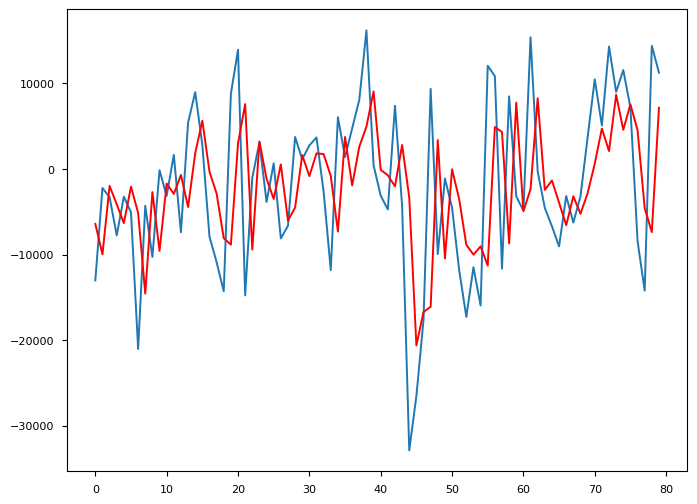

In [10]:
# ARIMA with walk forward validation
from statsmodels.tsa.arima.model import ARIMA

history = [x for x in y_train]
observations = y_test.tolist()
predictions = list()

start = datetime.datetime.now()

# walk-forward validation
for t in range(len(observations)):
 model = ARIMA(history, order=(4,1,2))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = observations[t]
 history.append(obs)
 #print('predicted=%f, expected=%f' % (yhat, obs))

end = datetime.datetime.now()

# evaluate forecasts
run_time = end-start
print('Model Runtime: {}'.format(run_time.total_seconds()))
rmse = np.sqrt(mean_squared_error(observations, predictions))
print('Test RMSE: %.3f' % rmse)
MAPE = mean_absolute_percentage_error(observations, predictions)
print('Test MAPE: %.3f' % MAPE)
smape_ = smape(np.array(observations), np.array(predictions))
print('TEST SMAPE: {:0.2f}% '.format(smape_))
r2 = r2_score(observations, predictions)
print('TEST R_squared: {:0.2f} '.format(r2))

# plot forecasts against actual outcomes
plt.plot(observations)
plt.plot(predictions, color='red')
plt.show()

## Load CA, KA, FA data

In [ ]:
def load_BOP_data(account_type,country_name):
  BOP = pd.read_excel(data_folder+'/{}_monthly.xls'.format(account_type),header=1)
  country = [x for x in BOP['REF_AREA.343 [desc.]'].unique() if country_name in x][0]
  country_BOP = BOP[BOP['REF_AREA.343 [desc.]']== country].reset_index(drop=True)
  useful_col2 = ['Obs. date','Obs. value']
  country_BOP = country_BOP[useful_col2]
  country_BOP = country_BOP[country_BOP['Obs. date']>'2001']
  country_BOP = country_BOP.sort_values(by='Obs. date',ascending=True).reset_index(drop=True)
  country_BOP = country_BOP.rename(columns={'Obs. date':'date'})
  if account_type == 'CA':
    country_BOP.rename(columns={'Obs. value':'Current_Account'},inplace=True)
  elif account_type == 'KA':
    country_BOP.rename(columns={'Obs. value':'Capital_Account'},inplace=True)
  elif account_type == 'FA':
    country_BOP.rename(columns={'Obs. value':'Financial_Account'},inplace=True)
  country_BOP['date'] = pd.to_datetime(country_BOP.date).dt.to_period('M')
  return country_BOP

In [ ]:
# load monthly BOP data
CA_DE  = load_BOP_data('CA','Spain')
#KA_DE = load_BOP_data('KA','Germany')
FA_DE = load_BOP_data('FA','Spain')

In [ ]:
# merge into one dataframe
BOP_DE = CA_DE.merge(FA_DE,on='date')

In [ ]:
BOP_DE.tail()

,date,Current_Account,Financial_Account
260,2022-09,316.0,-97.0
261,2022-10,1585.0,-682.0
262,2022-11,4212.0,-615.0
263,2022-12,1204.0,7744.0
264,2023-01,3274.0,3690.0


In [ ]:
# calculate the monthly difference
BOP_DE['Current_Account_1st_diff'] = BOP_DE['Current_Account'].diff(1)
#BOP_DE['Capital_Account_1st_diff'] = BOP_DE['Capital_Account'].diff(1)
BOP_DE['Financial_Account_1st_diff'] = BOP_DE['Financial_Account'].diff(1)

In [ ]:
# rearrange columns
BOP_DE = BOP_DE[['date','Current_Account_1st_diff',
       #'Capital_Account_1st_diff',
       'Financial_Account_1st_diff']]

In [ ]:
BOP_DE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 265 entries, 0 to 264
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype    
---  ------                      --------------  -----    
 0   date                        265 non-null    period[M]
 1   Current_Account_1st_diff    264 non-null    float64  
 2   Financial_Account_1st_diff  264 non-null    float64  
dtypes: float64(2), period[M](1)
memory usage: 8.3 KB


## Load other features


In [ ]:
def load_GDP_data(country_name):
  GDP = pd.read_excel(data_folder+'/GDP_unadjusted.xls',header=1)
  country = [x for x in GDP['REF_AREA.249 [desc.]'].unique() if country_name in x][0]
  country_GDP = GDP[GDP['REF_AREA.249 [desc.]'] == country].reset_index(drop=True)
  col_to_use = ['Obs. formatted date','Obs. value']
  country_GDP = country_GDP[col_to_use]
  country_GDP.rename(columns={'Obs. value':'GDP'},inplace=True)
  country_GDP = country_GDP.sort_values(by='Obs. formatted date',ascending=True).reset_index(drop=True)
  country_GDP = country_GDP[country_GDP['Obs. formatted date']>'2001'].reset_index(drop=True)
  country_GDP = country_GDP.rename(columns={'Obs. formatted date':'date'})
  country_GDP['date'] = pd.to_datetime(country_GDP['date']).dt.to_period('M')
  return country_GDP

In [ ]:
# load GDP data
GDP_data = load_GDP_data('Spain').reset_index(drop=True)

In [ ]:
# calculate GDP quarterly difference
GDP_data['GDP'] = GDP_data['GDP'].diff(1)

bond data : https://fred.stlouisfed.org/series/IRLTLT01DEM156N

In [ ]:
# load government bond data
bond_data = pd.read_csv(data_folder+'/Spain_bond.csv')
bond_data = bond_data[bond_data['DATE']>'2001'].reset_index(drop=True)
bond_data.rename(columns={'DATE':'date','IRLTLT01LUM156N':'Gov_bond_yield'},inplace=True)
bond_data['date'] = pd.to_datetime(bond_data['date']).dt.to_period('M')

In [ ]:
bond_data.head()

,date,IRLTLT01ITM156N
0,2001-01,5.18310
1,2001-02,5.18368
2,2001-03,5.13048
3,2001-04,5.28228
4,2001-05,5.44870


In [ ]:
def load_Stress_data(country_name):
  GDP = pd.read_excel(data_folder+'/Country-Level Index of Financial Stress.xls',header=1)
  country = [x for x in GDP['REF_AREA.276 [desc.]'].unique() if country_name in x][0]
  country_GDP = GDP[GDP['REF_AREA.276 [desc.]'] == country].reset_index(drop=True)
  col_to_use = ['Obs. formatted date','Obs. value']
  country_GDP = country_GDP[col_to_use]
  country_GDP.rename(columns={'Obs. value':'Stress_indicator'},inplace=True)
  country_GDP = country_GDP.sort_values(by='Obs. formatted date',ascending=True).reset_index(drop=True)
  country_GDP = country_GDP[country_GDP['Obs. formatted date']>'2001'].reset_index(drop=True)
  country_GDP = country_GDP.rename(columns={'Obs. formatted date':'date'})
  country_GDP['date'] = pd.to_datetime(country_GDP['date']).dt.to_period('M')
  return country_GDP

In [ ]:
# load financial stress indicator data
stress_data = load_Stress_data('Spain')

In [ ]:
def load_inflation_data(country_name):
  GDP = pd.read_excel(data_folder+'/inflation rate.xls',header=1)
  country = [x for x in GDP['REF_AREA.19 [desc.]'].unique() if country_name in x][0]
  country_GDP = GDP[GDP['REF_AREA.19 [desc.]'] == country].reset_index(drop=True)
  col_to_use = ['Obs. formatted date','Obs. value']
  country_GDP = country_GDP[col_to_use]
  country_GDP.rename(columns={'Obs. value':'inflation_rate'},inplace=True)
  country_GDP = country_GDP.sort_values(by='Obs. formatted date',ascending=True).reset_index(drop=True)
  country_GDP = country_GDP[country_GDP['Obs. formatted date']>'2001'].reset_index(drop=True)
  country_GDP = country_GDP.rename(columns={'Obs. formatted date':'date'})
  country_GDP['date'] = pd.to_datetime(country_GDP['date']).dt.to_period('M')
  return country_GDP

In [ ]:
# load inflation data
inflation_data = load_inflation_data('Spain')

In [ ]:
inflation_data.head()

,date,inflation_rate
0,2001-01,2.9
1,2001-02,2.7
2,2001-03,3.0
3,2001-04,3.6
4,2001-05,3.8


## Feature preparation

### Moving Average

In [ ]:
# merge all features into one dataframe
data_lst = [Spain_T2,bond_data,stress_data,inflation_data,GDP_data]
feature_df = BOP_DE.copy()
for data in data_lst:
  #print(data)
  feature_df = feature_df.merge(data,how='left',on='date')

feature_df.drop(columns='T2_balance',inplace=True)

In [ ]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 265 entries, 0 to 264
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype    
---  ------                      --------------  -----    
 0   date                        265 non-null    period[M]
 1   Current_Account_1st_diff    264 non-null    float64  
 2   Financial_Account_1st_diff  264 non-null    float64  
 3   IRLTLT01ITM156N             265 non-null    float64  
 4   Stress_indicator            265 non-null    float64  
 5   inflation_rate              265 non-null    float64  
 6   GDP                         88 non-null     float64  
dtypes: float64(6), period[M](1)
memory usage: 16.6 KB


In [ ]:
feature_df.head()

,date,Current_Account_1st_diff,Financial_Account_1st_diff,IRLTLT01ITM156N,Stress_indicator,inflation_rate,GDP
0,2001-01,NaN,NaN,5.18310,0.0906,2.9,NaN
1,2001-02,1638.0,2783.0,5.18368,0.0626,2.7,NaN
2,2001-03,-312.0,-963.0,5.13048,0.0660,3.0,NaN
3,2001-04,1154.0,1862.0,5.28228,0.0973,3.6,9865.0
4,2001-05,-578.0,-692.0,5.44870,0.0869,3.8,NaN


In [ ]:
feature_df.shape

(265, 7)

In [ ]:
feature_df[['GDP']] = feature_df[['GDP']].ffill()

In [ ]:
#feature_df[['total_redemptions']] = feature_df[['total_redemptions']].fillna(0)

In [ ]:
feature_df.isna().sum()

date                          0
Current_Account_1st_diff      1
Financial_Account_1st_diff    1
1st_diff                      1
1st_diff_1lag                 2
1st_diff_7lag                 8
IRLTLT01ITM156N               0
Stress_indicator              0
inflation_rate                0
GDP                           3
dtype: int64

In [ ]:
#feature_df = feature_df[feature_df['date']>'2008'].reset_index(drop=True)

In [ ]:
# calculate moving averages
feature_df['Moving_Avg_3m'] = feature_df['1st_diff'].rolling(3,min_periods=1).mean().shift(1)
#feature_df['Moving_Avg_6m'] = feature_df['1st_diff'].rolling(6,min_periods=1).mean().shift(1)
feature_df['Moving_Avg_9m'] = feature_df['1st_diff'].rolling(9,min_periods=1).mean().shift(1)
#feature_df['Moving_Avg_12m'] = feature_df['1st_diff'].rolling(12,min_periods=1).mean().shift(1)

In [ ]:
feature_df.head()

,date,Current_Account_1st_diff,Financial_Account_1st_diff,1st_diff,1st_diff_1lag,1st_diff_7lag,IRLTLT01ITM156N,Stress_indicator,inflation_rate,GDP,Moving_Avg_3m,Moving_Avg_9m
0,2001-01,NaN,NaN,NaN,NaN,NaN,5.18310,0.0906,2.9,NaN,NaN,NaN
1,2001-02,1638.0,2783.0,-7996.91,NaN,NaN,5.18368,0.0626,2.7,NaN,NaN,NaN
2,2001-03,-312.0,-963.0,-9282.86,-7996.91,NaN,5.13048,0.0660,3.0,NaN,-7996.910000,-7996.910000
3,2001-04,1154.0,1862.0,874.31,-9282.86,NaN,5.28228,0.0973,3.6,9865.0,-8639.885000,-8639.885000
4,2001-05,-578.0,-692.0,-94.21,874.31,NaN,5.44870,0.0869,3.8,9865.0,-5468.486667,-5468.486667


In [ ]:
# calculate volatility
#feature_df['Volatility_6m'] = feature_df['1st_diff'].rolling(6,min_periods=6).std().shift(1)*np.sqrt(6)
#feature_df['Volatility_6m'] = feature_df['1st_diff'].rolling(6,min_periods=1).std().shift(1)*np.sqrt(6)
feature_df['Volatility_24m'] = feature_df['1st_diff'].rolling(24,min_periods=24).std().shift(1)*np.sqrt(24)
#feature_df['Volatility_12m'] = feature_df['1st_diff'].rolling(12,min_periods=1).std().shift(1)*np.sqrt(12)

### Encode ordnial

In [ ]:
def encode_cyclicals(df_x):
    #"month"

    df_x['month_sin'] = np.sin(2*np.pi*df_x.month/12)
    df_x['month_cos'] = np.cos(2*np.pi*df_x.month/12)
    df_x.drop('month', axis=1, inplace=True)

    return df_x

In [ ]:
# encode month using sine and cosine function
feature_df['year'] = feature_df['date'].dt.year
feature_df['month'] = feature_df['date'].dt.month
feature_df = feature_df.drop(columns='date')
feature_df = encode_cyclicals(feature_df)

In [ ]:
# fill na with 0
feature_df.fillna(0,inplace=True)

In [ ]:
feature_df.reset_index(drop=True,inplace=True)

<Axes: >

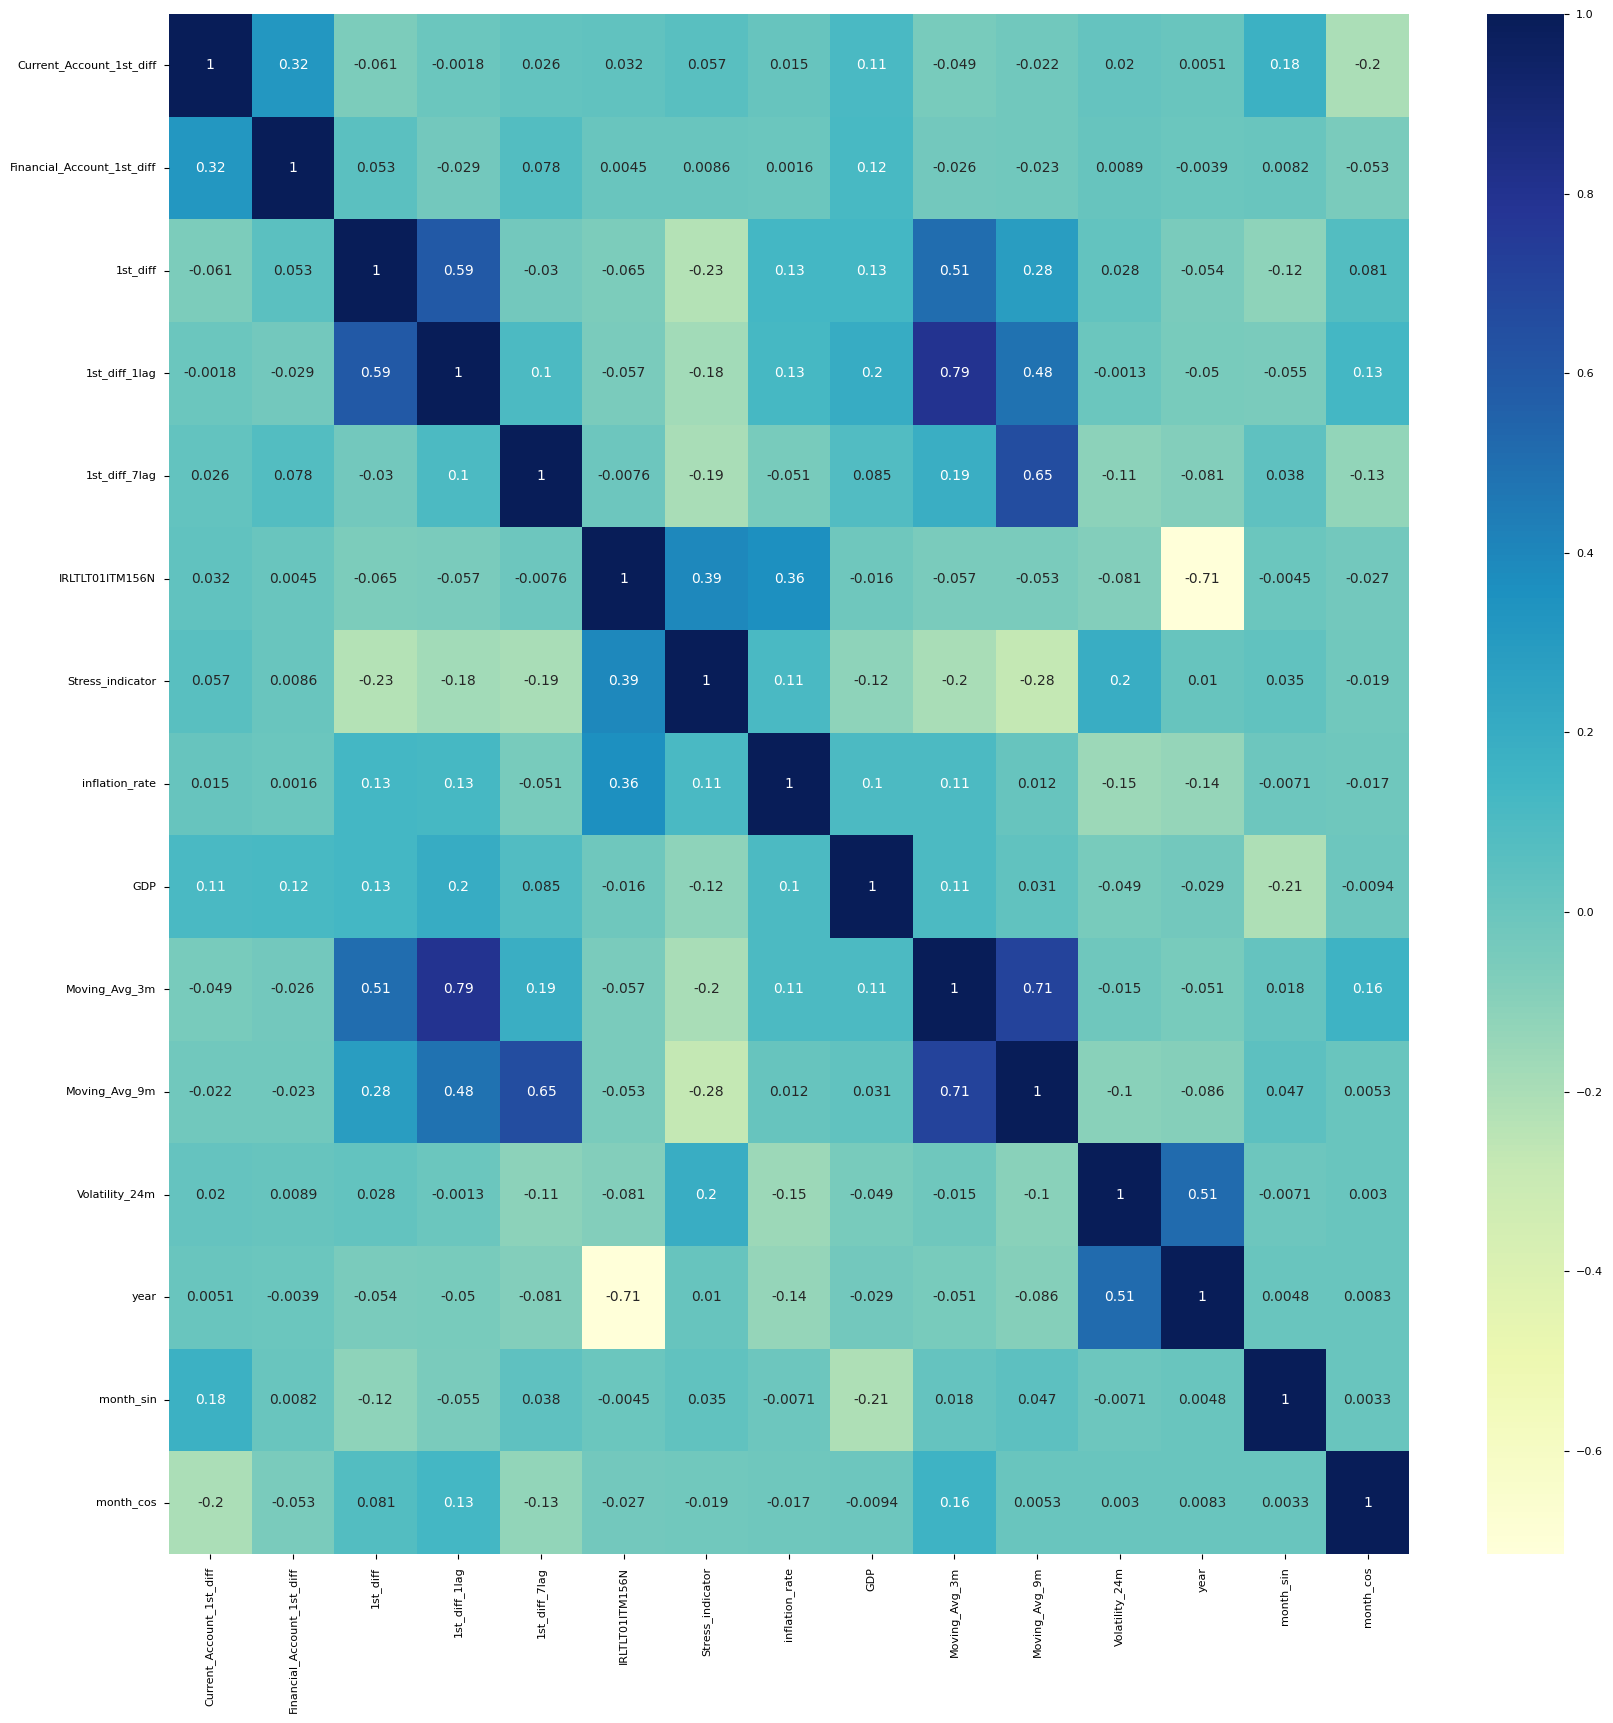

In [ ]:
import seaborn as sns
# check feature correlations
corr_df = feature_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_df,annot=True, cmap="YlGnBu")

In [ ]:
from sklearn.model_selection import train_test_split
# split all into train and test dataset
X_train, X_test ,y_train, y_test = train_test_split(feature_df.drop(columns='1st_diff'), feature_df["1st_diff"], test_size=0.3, shuffle=False)

In [ ]:
X_train.head()

,Current_Account_1st_diff,Financial_Account_1st_diff,1st_diff_1lag,1st_diff_7lag,IRLTLT01ITM156N,Stress_indicator,inflation_rate,GDP,Moving_Avg_3m,Moving_Avg_9m,Volatility_24m,year,month_sin,month_cos
0,0.0,0.0,0.00,0.0,5.18310,0.0906,2.9,0.0,0.000000,0.000000,0.0,2001,0.500000,8.660254e-01
1,1638.0,2783.0,0.00,0.0,5.18368,0.0626,2.7,0.0,0.000000,0.000000,0.0,2001,0.866025,5.000000e-01
2,-312.0,-963.0,-7996.91,0.0,5.13048,0.0660,3.0,0.0,-7996.910000,-7996.910000,0.0,2001,1.000000,6.123234e-17
3,1154.0,1862.0,-9282.86,0.0,5.28228,0.0973,3.6,9865.0,-8639.885000,-8639.885000,0.0,2001,0.866025,-5.000000e-01
4,-578.0,-692.0,874.31,0.0,5.44870,0.0869,3.8,9865.0,-5468.486667,-5468.486667,0.0,2001,0.500000,-8.660254e-01


In [ ]:
X_test.head()

,Current_Account_1st_diff,Financial_Account_1st_diff,1st_diff_1lag,1st_diff_7lag,IRLTLT01ITM156N,Stress_indicator,inflation_rate,GDP,Moving_Avg_3m,Moving_Avg_9m,Volatility_24m,year,month_sin,month_cos
185,-472.0,-939.0,-15505.50,-11670.52,1.45346,0.1844,-0.9,15943.0,-6231.873333,-6156.598889,40087.907634,2016,1.224647e-16,-1.000000e+00
186,2077.0,8378.0,-8420.97,-4054.74,1.22722,0.0792,-0.7,-5994.0,-9461.013333,-7602.593333,36982.812544,2016,-5.000000e-01,-8.660254e-01
187,-1287.0,-7026.0,-6124.71,-7630.37,1.17635,0.0605,-0.3,-5994.0,-10017.060000,-7033.084444,33018.487259,2016,-8.660254e-01,-5.000000e-01
188,-1482.0,-996.0,-13027.56,-6700.83,1.26606,0.0721,0.0,-5994.0,-9191.080000,-7183.866667,34157.743896,2016,-1.000000e+00,-1.836970e-16
189,59.0,8531.0,-2220.06,1266.45,1.45047,0.0649,0.5,14623.0,-7124.110000,-6980.013333,32408.214156,2016,-8.660254e-01,5.000000e-01


## Evaluation helper

In [ ]:
# function to calculate SMAPE
def smape(A, F):
      return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

# function to calculate RMSE, MAPE, SMAPE and R2
def evaluate(actual, predictions):
    #predictions = model.predict(test_features)
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    mape = mean_absolute_percentage_error(actual, predictions)
    smape_ = smape(actual, predictions)
    r2 = r2_score(actual, predictions)
    print('Model Performance')
    print('TEST RMSE: {:0.2f} '.format(rmse))
    print('TEST MAPE: {:0.2f} '.format(mape))
    print('TEST SMAPE: {:0.2f}% '.format(smape_))
    print('TEST R_squared: {:0.2f} '.format(r2))

## Linear regression

                            OLS Regression Results                            
Dep. Variable:               1st_diff   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     13.72
Date:                Tue, 20 Jun 2023   Prob (F-statistic):           1.93e-21
Time:                        14:59:27   Log-Likelihood:                -1918.7
No. Observations:                 185   AIC:                             3867.
Df Residuals:                     170   BIC:                             3916.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

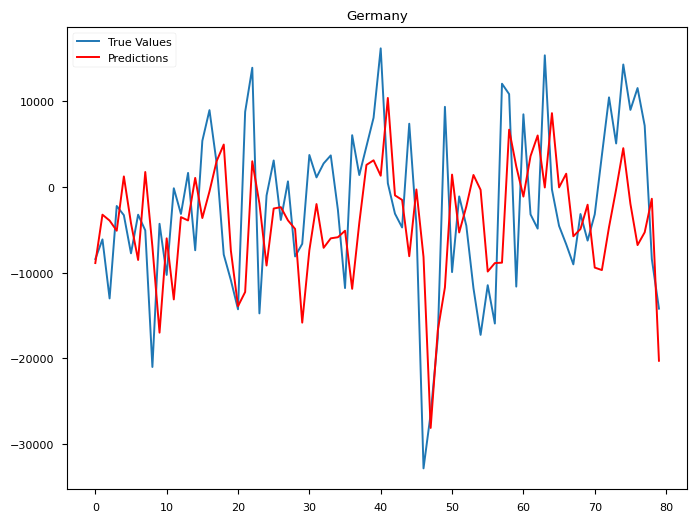

In [ ]:
import statsmodels.api as sm
# linear regression to check the feature significance
simple_lr = sm.OLS(y_train,sm.add_constant(X_train))
results = simple_lr.fit()
print(results.summary())
# linear regression predictions and evaluations
predictions = simple_lr.predict(results.params,sm.add_constant(X_test))
evaluate(y_test,predictions)
plt.title('Germany')
plt.plot(y_test.reset_index(drop=True),label='True Values')
plt.plot(predictions, color='red', label='Predictions')
plt.legend(loc="upper left")
plt.show()

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

N_ESTIMATORS = 50
RANDOM_STATE = 452

#### Normal model

Model Performance
TEST RMSE: 10492.00 
TEST MAPE: 2.12 
TEST SMAPE: 127.48% 
TEST R_squared: -0.20 


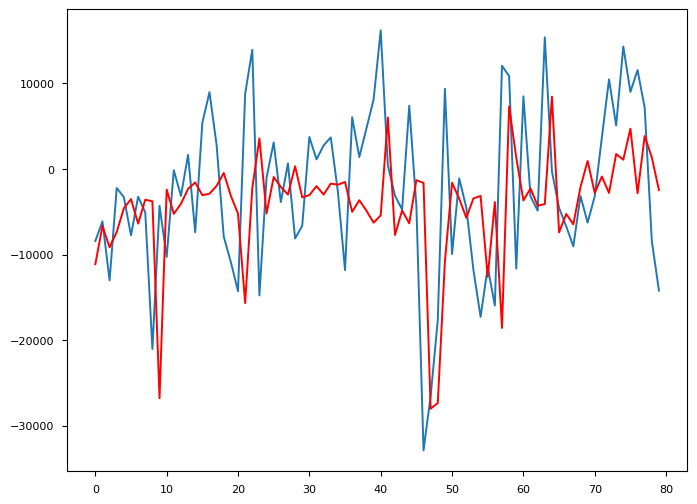

In [ ]:
# untuned random forest
RF_base_model = RandomForestRegressor(n_estimators=N_ESTIMATORS,random_state=RANDOM_STATE)
model_fit = RF_base_model.fit(X_train,y_train)
output = model_fit.predict(X_test)
#run_time = end-start
#print('Model Runtime: {}'.format(run_time.total_seconds()))
evaluate(y_test,output)
observations = y_test.tolist()
plt.plot(y_test.reset_index(drop=True))
plt.plot(output, color='red')
plt.show()

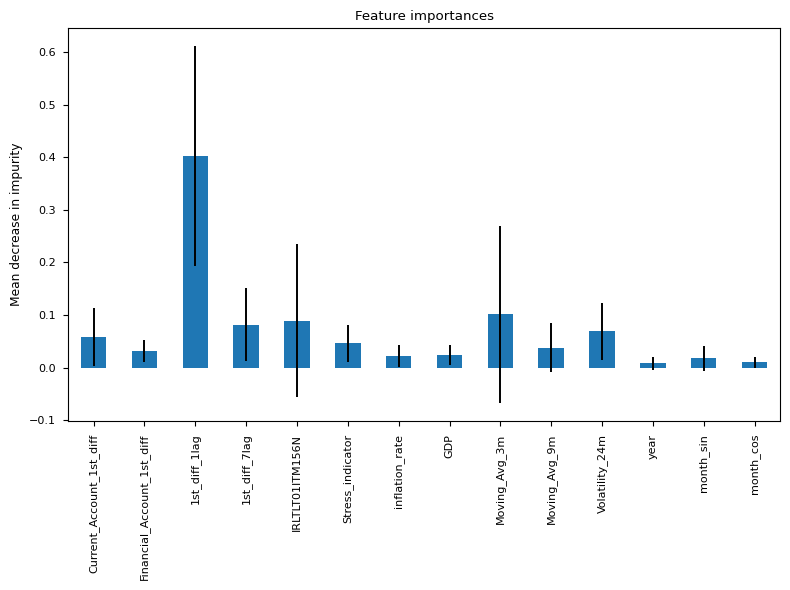

In [ ]:
# untuned random forest feature importance
importances = model_fit.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)
std = np.std([tree.feature_importances_ for tree in model_fit.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Cross Validation - TimeSeriesSplit

In [ ]:

randomForest = RandomForestRegressor()
tscv_anchored = TimeSeriesSplit(n_splits = 5)

In [ ]:
# tuning random forest with randomized search
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8, 16]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

gsearch2 = RandomizedSearchCV(estimator=randomForest, n_iter = 500, cv=tscv_anchored, param_distributions=random_grid,verbose=2, random_state=100,n_jobs = -1)
gsearch2.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(), n_iter=500, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 7, 10, 12, 15, 17, 20,
                                                      22, 25, 27, 30, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 8, 16],
                                        'min_samples_split': [5, 10, 15, 20],
                                        'n_estimators': [50, 57, 65, 73, 81, 89,
                                                         97, 105, 113, 121, 128,
                                                         136, 144, 152, 160,
                                                         168, 176, 184, 192,
                                                         200]},
                   random_state=100, verbose=2)

In [ ]:
def smape(A, F):
      return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

def evaluate_cv(model, test_features, test_labels):
    predictions = model.predict(test_features)
    rmse = np.sqrt(mean_squared_error(test_labels, predictions))
    mape = mean_absolute_percentage_error(test_labels, predictions)
    smape_ = smape(test_labels, predictions)
    r2 = r2_score(test_labels, predictions)
    print('Model Performance')
    print('TEST RMSE: {:0.2f} '.format(rmse))
    print('TEST MAPE: {:0.2f} '.format(mape))
    print('TEST SMAPE: {:0.2f}% '.format(smape_))
    print('TEST R_squared: {:0.2f} '.format(r2))

    return predictions

In [ ]:
# tuned random forest
best_random = gsearch2.best_estimator_
predictions_anchored = evaluate_cv(best_random, X_test, y_test)

Model Performance
TEST RMSE: 9562.01 
TEST MAPE: 1.96 
TEST SMAPE: 130.08% 
TEST R_squared: 0.00 


In [ ]:
best_random

RandomForestRegressor(bootstrap=False, max_features='log2', min_samples_leaf=16,
                      min_samples_split=15, n_estimators=97)

In [ ]:
# save tuned model
import pickle
model_folder = '/content/drive/MyDrive/Thesis/model/Spain/'
filename = 'tuned_rf_lux.sav'
pickle.dump(best_random, open(model_folder + filename, 'wb'))
loaded_model = pickle.load(open(model_folder+filename, 'rb'))
result = loaded_model.predict(X_test)
evaluate(result,y_test)

Model Performance
TEST RMSE: 9562.01 
TEST MAPE: 8.15 
TEST SMAPE: 130.08% 
TEST R_squared: -5.21 


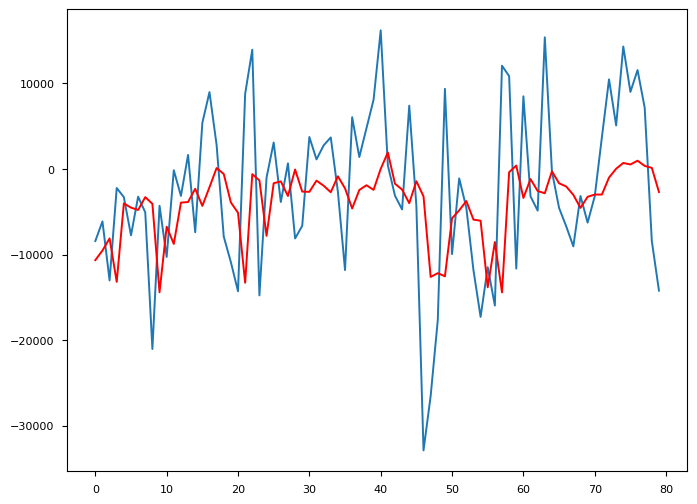

In [ ]:
# plot predictions of tuned model and true values
plt.plot(y_test.reset_index(drop=True))
plt.plot(predictions_anchored, color='red')
plt.show()

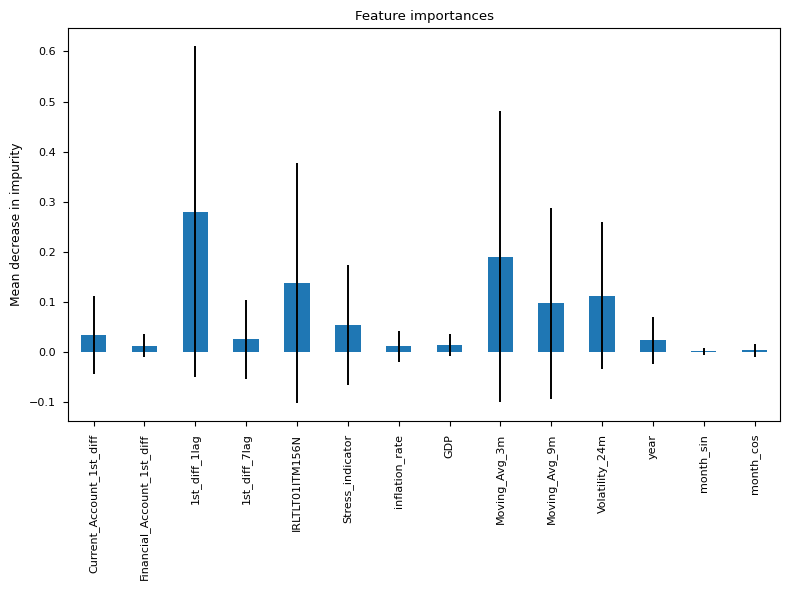

In [ ]:
# tuned model feature importance
importances = best_random.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)
std = np.std([tree.feature_importances_ for tree in best_random.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## XGBoost

Model Performance
TEST RMSE: 10462.06 
TEST MAPE: 2.85 
TEST SMAPE: 127.03% 
TEST R_squared: -0.19 


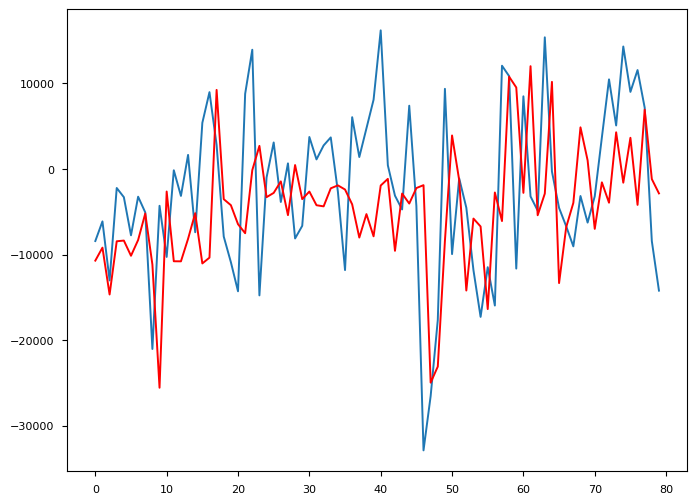

In [ ]:
# untuned xgboost
from xgboost import XGBRegressor

xgboost = XGBRegressor(objective='reg:squarederror')

xgb_model = xgboost.fit(X_train,y_train)
output = xgb_model.predict(X_test)

evaluate(y_test,output)

plt.plot(y_test.reset_index(drop=True))
plt.plot(output, color='red')
plt.show()


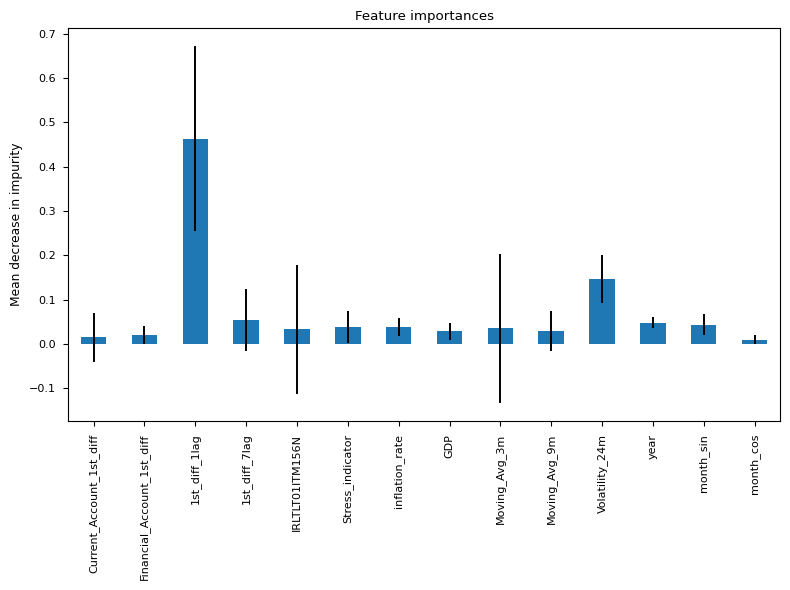

In [ ]:
# untuned model feature importance
importances = xgb_model.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)
#std = np.std([tree.feature_importances_ for tree in xgb_model.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Cross Validation

In [ ]:
# tuning xgboost with randomized search of parameters
tscv_anchored = TimeSeriesSplit(n_splits = 5)
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

gsearch3 = RandomizedSearchCV(estimator=xgboost, n_iter = 200, cv=tscv_anchored, param_distributions=random_grid,verbose=2, random_state=42, n_jobs = -1)
gsearch3.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[19:38:31] WARNING: ../src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=No...
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8, 10],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=42, verbose=2)

In [ ]:
# tuned xgboost
best_xgb = gsearch3.best_estimator_
output = evaluate_cv(best_xgb, X_test, y_test)

Model Performance
TEST RMSE: 10439.63 
TEST MAPE: 2.96 
TEST SMAPE: 125.21% 
TEST R_squared: -0.19 


In [ ]:
# save tuned model
import pickle
model_folder = '/content/drive/MyDrive/Thesis/model/Spain/'
filename = 'tuned_xgb.sav'
pickle.dump(model_fit, open(model_folder + filename, 'wb'))
loaded_model = pickle.load(open(model_folder+filename, 'rb'))
loaded_model.score(X_test, y_test)

-0.2012236303730215

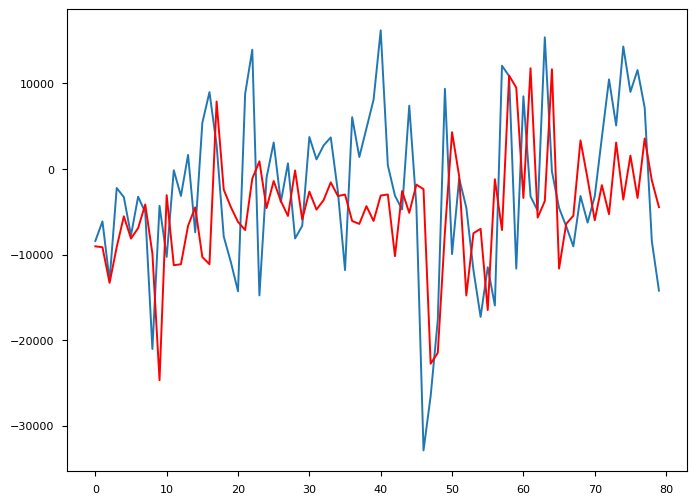

In [ ]:
# plot true values and predictions of tuned model
plt.plot(y_test.reset_index(drop=True))
plt.plot(output, color='red')
plt.show()

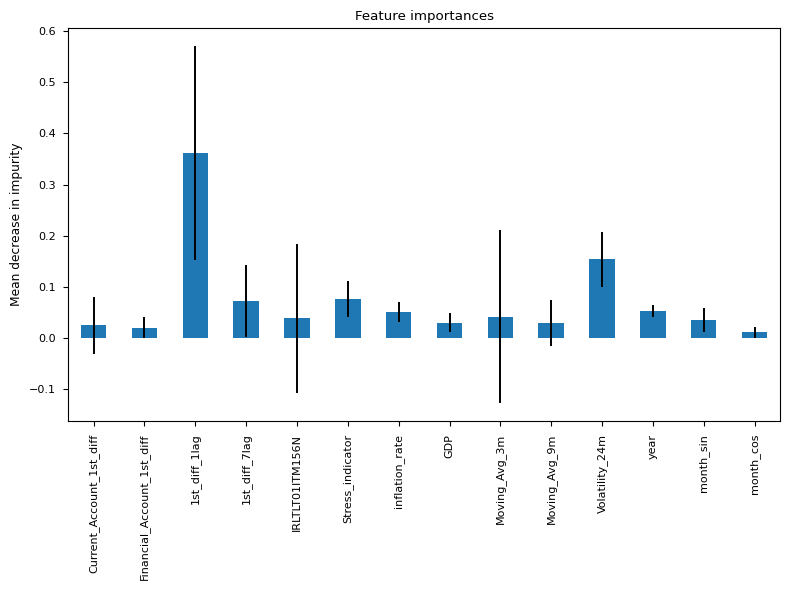

In [ ]:
# tuned model feature importance analysis
importances = best_xgb.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)
#std = np.std([tree.feature_importances_ for tree in model_fit.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## LGBM

In [ ]:
# params = {
#     'objective': 'regression',
#     'device': 'cpu',
#     'boosting': 'goss',#method of boosting (gbdt, rf, dart, goss) --> dart<gbdt<goss ( provides a new sampling method for GBDT by separating those instances with larger gradients)
#     'num_iterations': 600,
#     'lambda_l1':15, #L1 regularization ---> reduces both overfitting and test error
#     'lambda_l2': 2, # L2 regularization
#     'max_depth':-1, #limit the max depth for tree model
#     'max_bin':500, # Small number of bins may reduce training accuracy but can deal with over-fitting
#     'num_leaves': 200, #max number of leaves in one tree
#     'colsample_bytree': 1, #% features used while const tree
#     'subsample': 0.8, # subsample ratio of the training instance
#     'learning_rate': 0.04,
#     'metric': 'rmse',
#     'verbose': -1 #debugging

# }

Model Performance
TEST RMSE: 10714.93 
TEST MAPE: 2.61 
TEST SMAPE: 145.72% 
TEST R_squared: -0.25 


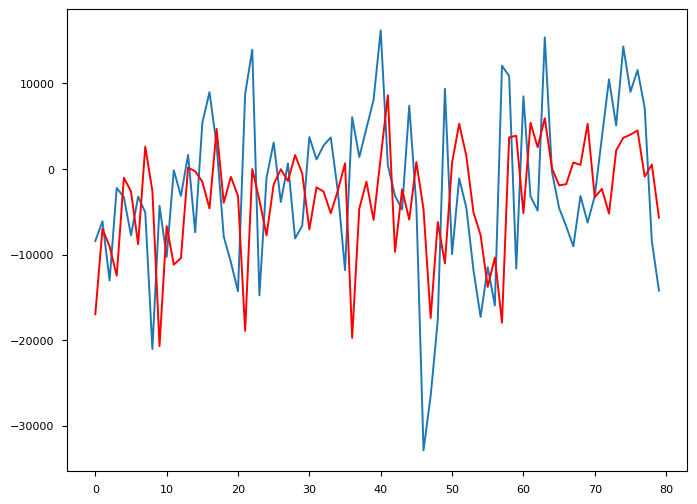

In [ ]:
# untuned lgbm
import lightgbm
from lightgbm import LGBMRegressor
import datetime
from sklearn.metrics import mean_squared_error

model_lgb = LGBMRegressor()
#model_lgb.set_params(**params)
model_fit = model_lgb.fit(X_train,y_train,eval_metric ='rmse')
output = model_fit.predict(X_test)
evaluate(y_test,output)

#run_time = end-start
#print('Model Runtime: {}'.format(run_time.total_seconds()))

observations = y_test.tolist()
plt.plot(y_test.reset_index(drop=True))
plt.plot(output, color='red')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

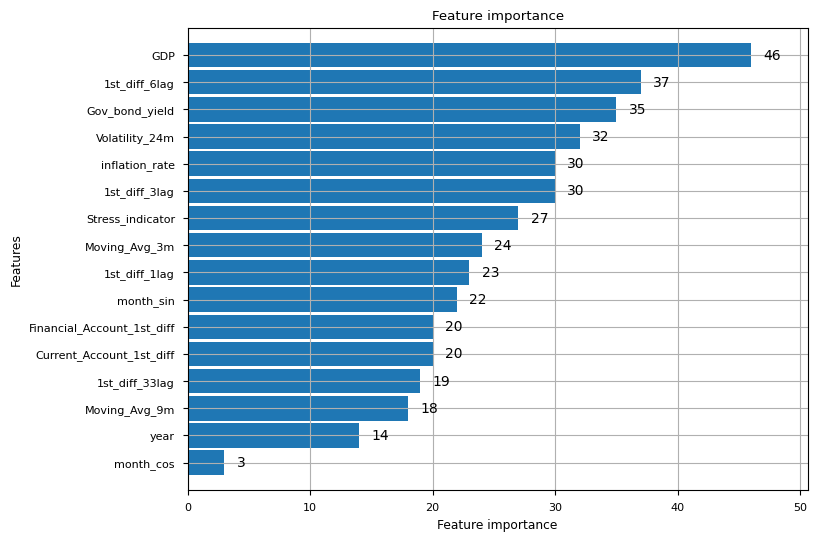

In [ ]:
# untuned model feature importance
lightgbm.plot_importance(model_fit, max_num_features = 60, height=.9)

### Model tuning

In [ ]:
# tuning lgbm with randomized search
param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1],
              'n_estimators' : [int(x) for x in np.linspace(10,300, num = 30)],
              'num_leaves': [int(x) for x in np.linspace(10, 100, num = 10)],
              'min_child_samples': [int(x) for x in np.linspace(10, 50, num = 10)] ,
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              #'subsample': [int(x) for x in np.linspace(1, 10, num = 5)],
              'max_depth': [-1, 1, 2, 3, 5, 8, 10, 15, 20],
              #'colsample_bytree': sp_uniform(loc = 0.4, scale = 0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
              }

# Number of combinations
n_iter = 500
tscv_anchored = TimeSeriesSplit(n_splits = 5)
# Intializing lgbm and lunching the search
lgbm_clf = LGBMRegressor(random_state = 42, n_jobs = -1)
grid_search = RandomizedSearchCV(
    estimator = lgbm_clf, param_distributions = param_test,
    n_iter = n_iter,
    scoring = 'neg_mean_squared_error',
    cv = tscv_anchored,
    refit = True,
    random_state = 42,
    verbose = True)

grid_search.fit(X_train, y_train, )#**fit_params
opt_parameters = grid_search.best_params_


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


In [ ]:
def smape(A, F):
      return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

def evaluate_cv(model, test_features, test_labels):
    predictions = model.predict(test_features)
    rmse = np.sqrt(mean_squared_error(test_labels, predictions))
    mape = mean_absolute_percentage_error(test_labels, predictions)
    smape_ = smape(test_labels, predictions)
    r2 = r2_score(test_labels, predictions)
    print('Model Performance')
    print('TEST RMSE: {:0.2f} '.format(rmse))
    print('TEST MAPE: {:0.2f} '.format(mape))
    print('TEST SMAPE: {:0.2f}% '.format(smape_))
    print('TEST R_squared: {:0.2f} '.format(r2))

    return predictions

In [ ]:
# tuned lgbm
best_lgbm = grid_search.best_estimator_
predictions_anchored = evaluate_cv(best_lgbm, X_test, y_test)

Model Performance
TEST RMSE: 10711.53 
TEST MAPE: 2.65 
TEST SMAPE: 135.60% 
TEST R_squared: -0.25 


In [ ]:
best_lgbm

LGBMRegressor(learning_rate=0.08, max_depth=15, min_child_samples=32,
              min_child_weight=1e-05, n_estimators=250, num_leaves=70,
              random_state=42, reg_alpha=10, reg_lambda=1)

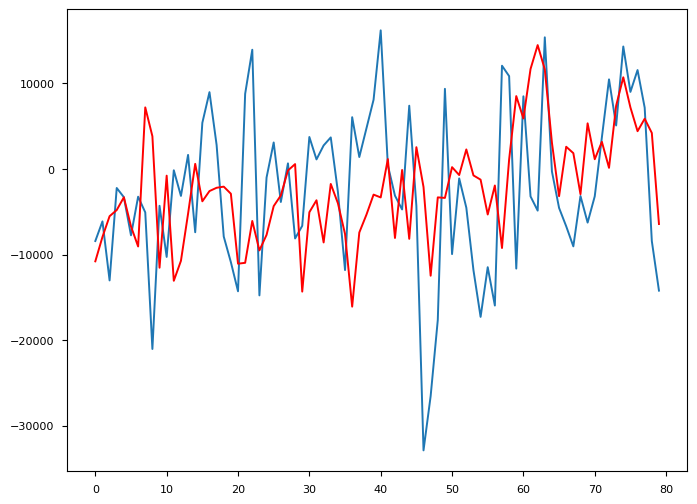

In [ ]:
# plot true values and predictions
plt.plot(y_test.reset_index(drop=True))
plt.plot(predictions_anchored, color='red')
plt.show()

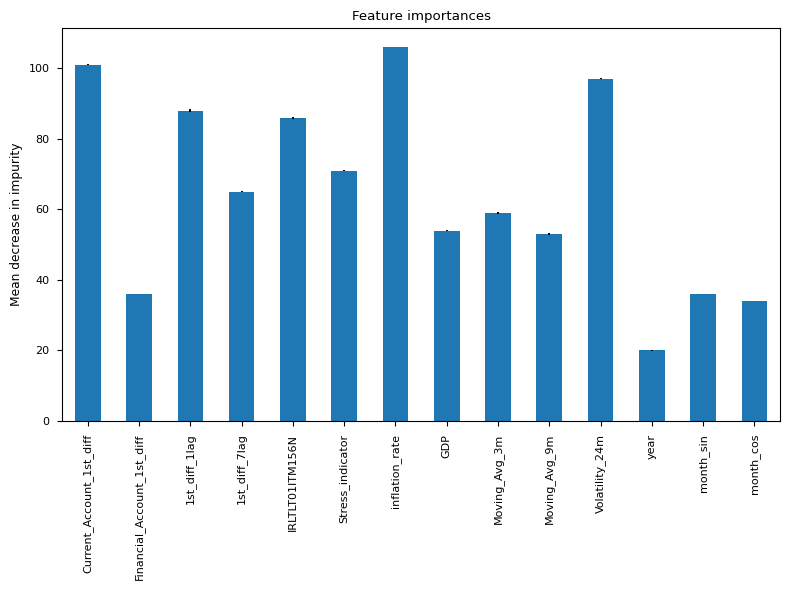

In [ ]:
# tuned lgbm feature importances
importances = best_lgbm.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)
#std = np.std([tree.feature_importances_ for tree in best_random.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## CatBoost

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.2 MB/s eta 0:00:00


In [ ]:
import catboost as cb

In [ ]:
# catboost train and test dataset
train_dataset = cb.Pool(X_train, y_train)
test_dataset = cb.Pool(X_test, y_test)

In [ ]:
# tuning catboost model
model = cb.CatBoostRegressor(loss_function='RMSE')
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset)

流式输出内容被截断，只能显示最后 5000 行内容。
6:	learn: 10379.9910949	test: 10764.9338337	best: 10764.9338337 (6)	total: 43.6ms	remaining: 1.2s
7:	learn: 10262.8856544	test: 10696.9936116	best: 10696.9936116 (7)	total: 59.5ms	remaining: 1.43s
8:	learn: 10128.6490092	test: 10597.5681476	best: 10597.5681476 (8)	total: 72.8ms	remaining: 1.54s
9:	learn: 10008.5506756	test: 10523.9492048	best: 10523.9492048 (9)	total: 76.5ms	remaining: 1.45s
10:	learn: 9867.8525915	test: 10434.6756336	best: 10434.6756336 (10)	total: 79.9ms	remaining: 1.37s
11:	learn: 9757.4549956	test: 10341.9381018	best: 10341.9381018 (11)	total: 87.3ms	remaining: 1.37s
12:	learn: 9642.5851240	test: 10257.8278835	best: 10257.8278835 (12)	total: 94.5ms	remaining: 1.36s
13:	learn: 9516.9260814	test: 10189.9458921	best: 10189.9458921 (13)	total: 103ms	remaining: 1.37s
14:	learn: 9392.0457295	test: 10093.6346568	best: 10093.6346568 (14)	total: 109ms	remaining: 1.34s
15:	learn: 9279.7804453	test: 10053.2139112	best: 10053.2139112 (15)	total: 118m

{'params': {'depth': 4,
  'iterations': 150,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [ ]:
# catboost model result
pred = model.predict(X_test)
evaluate(y_test, pred)

Model Performance
TEST RMSE: 11047.33 
TEST MAPE: 2.26 
TEST SMAPE: 141.28% 
TEST R_squared: -0.33 


## SVM

In [ ]:
# untuned SVM
from sklearn import svm
regr = svm.SVR(kernel='sigmoid')
svm_model = regr.fit(X_train,y_train)
svm_pred = svm_model.predict(X_test)
evaluate(svm_pred,y_test)

Model Performance
TEST RMSE: 9842.23 
TEST MAPE: 50.26 
TEST SMAPE: 188.92% 
TEST R_squared: -9244654.61 


In [ ]:
# adjusted r2
r2_score(y_test.values, svm_pred)

-0.057047722128270584

In [ ]:
# adjusted MAPE
mean_absolute_percentage_error(y_test.values, svm_pred)

0.983199629996272

In [ ]:
# tuning SVM with grid search of paameters
tscv_anchored = TimeSeriesSplit(n_splits = 5)
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
grid = RandomizedSearchCV(regr, param_grid,refit=True,verbose=-1,n_jobs=-1,cv = tscv_anchored,n_iter=20)
grid.fit(X_train,y_train)

In [ ]:
# tuned SVM result
best_svm = grid.best_estimator_
predictions_anchored = evaluate_cv(best_svm, X_test, y_test)

In [ ]:
# save tuned SVM
import pickle
model_folder = '/content/drive/MyDrive/Thesis/model/Spain/'
filename = 'tuned_svm.sav'
pickle.dump(svm_model, open(model_folder + filename, 'wb'))

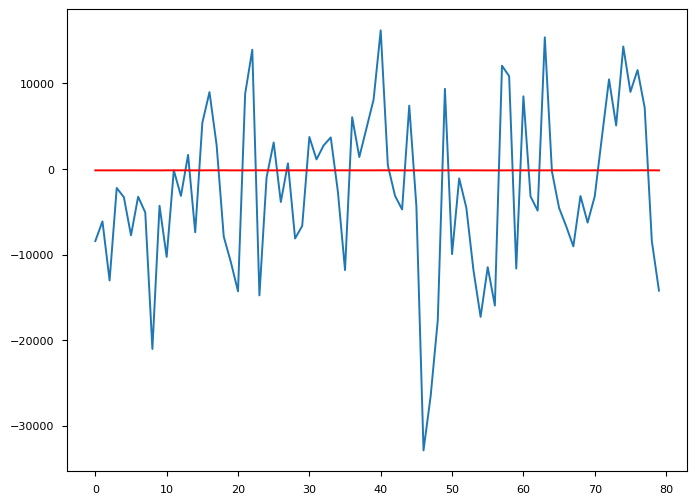

In [ ]:
# plot true values and tuned model predictions
plt.plot(y_test.reset_index(drop=True))
plt.plot(svm_pred, color='red')
plt.show()

## Stacked model

In [ ]:
# import saved models
stacked_df = pd.DataFrame()
loaded_rf = pickle.load(open(model_folder+'tuned_rf.sav', 'rb'))
loaded_lgbm = pickle.load(open(model_folder+'tuned_xgb.sav', 'rb'))
loaded_cb = pickle.load(open(model_folder+'tuned_svm.sav', 'rb'))
# make predictions on train data
stacked_df['random_forest'] = loaded_rf.predict(X_train)
stacked_df['XGB'] = loaded_lgbm.predict(X_train)
stacked_df['SVM'] = loaded_cb.predict(X_train)
# make predictions on test data
stacked_pred_df = pd.DataFrame()
stacked_pred_df['random_forest'] = loaded_rf.predict(X_test)
stacked_pred_df['XGB'] = loaded_lgbm.predict(X_test)
stacked_pred_df['SVM'] = loaded_cb.predict(X_test)

In [ ]:
stacked_df.head()

,random_forest,XGB,SVM
0,-847.781849,-183.3430,-158.310291
1,-1822.107234,-5340.1020,-158.252592
2,-3303.194787,-6404.4178,-162.021279
3,-3291.034062,-788.7624,-160.986743
4,-4870.812317,-626.8340,-157.908966


In [ ]:
stacked_pred_df.head()

,random_forest,XGB,SVM
0,-10069.127924,-11131.0848,-155.663602
1,-9146.426635,-6661.7672,-157.673048
2,-8051.585186,-9154.7254,-157.625928
3,-12735.695698,-7361.6946,-158.283505
4,-4204.351203,-4592.8250,-153.532667


In [ ]:
# stack models with linear regression and evaluate stacked model
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
stacked_model = linear.fit(stacked_df[['random_forest','XGB']],y_train)
stack_predictions = stacked_model.predict(stacked_pred_df[['random_forest','XGB',]])
evaluate(stack_predictions,y_test.values)

Model Performance
TEST RMSE: 10974.85 
TEST MAPE: 7.35 
TEST SMAPE: 130.68% 
TEST R_squared: -1.40 


In [ ]:
# adjusted r2
r2_score(y_test.values, stack_predictions)

-0.3143308614517051

In [ ]:
# adjust MAPE
mean_absolute_percentage_error(y_test.values, stack_predictions)

2.0141142322382786

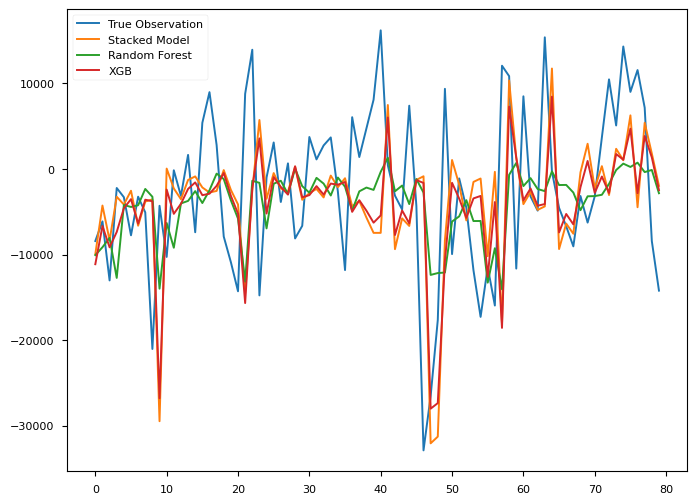

In [ ]:
# plot all model predictions and true values
plt.plot(y_test.reset_index(drop=True),label='True Observation')
plt.plot(stack_predictions,label='Stacked Model')
plt.plot(stacked_pred_df['random_forest'],label='Random Forest')
plt.plot(stacked_pred_df['XGB'],label='XGB')
#plt.plot(stacked_pred_df['SVM'],label='SVM')
plt.legend()
plt.show()